In [1]:
#  Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# Load dataset
file_path = '/content/drive/MyDrive/Project/online_retail_II-merged_dataset_final1.csv'
df = pd.read_csv(file_path)


/tmp/ipython-input-2830024469.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (1007914, 9)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'Revenue']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,pink cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,white cherry lights,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"record frame 7"" single size",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,strawberry ceramic trinket box,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [6]:
# Data cleaning and feature engineering
possible_price_cols = ['Price', 'UnitPrice', 'Unit Price', 'unit_price']
price_col = next((c for c in df.columns if c in possible_price_cols), None)
df.rename(columns={price_col: 'Price'}, inplace=True)

df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df.dropna(subset=['Quantity', 'Price'], inplace=True)
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Create target variable
df['Revenue'] = df['Quantity'] * df['Price']

# Select features
X = df[['Quantity', 'Price']]
y = np.log1p(df['Revenue'])


In [7]:
#Split data and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [8]:
# Baseline XGBoost Regressor
xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3
)

xgb_base.fit(X_train_scaled, y_train)
y_pred = xgb_base.predict(X_test_scaled)

# Reverse log-transform
y_pred_real = np.expm1(y_pred)
y_test_real = np.expm1(y_test)

mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print(f"Baseline Model Results:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")


Baseline Model Results:
MAE  : 3.39
RMSE : 371.27
R²   : 0.0775


In [11]:
# Step 7 — Optimized GridSearchCV (faster)
from sklearn.model_selection import GridSearchCV

# Smaller grid for quicker testing
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Use 3-fold for reasonable speed; can reduce to 2 if needed
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=2,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("GridSearch Complete")
print("Best Parameters:", grid_search.best_params_)
print("Best R² Score (CV):", grid_search.best_score_)


Fitting 2 folds for each of 16 candidates, totalling 32 fits
GridSearch Complete
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
Best R² Score (CV): 0.9946982688826602


In [12]:
# Evaluate best tuned model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test_scaled)

y_pred_best_real = np.expm1(y_pred_best)
y_test_real = np.expm1(y_test)

mae_best = mean_absolute_error(y_test_real, y_pred_best_real)
rmse_best = np.sqrt(mean_squared_error(y_test_real, y_pred_best_real))
r2_best = r2_score(y_test_real, y_pred_best_real)

print(f"\nTuned Model Results:")
print(f"MAE  : {mae_best:.2f}")
print(f"RMSE : {rmse_best:.2f}")
print(f"R²   : {r2_best:.4f}")



Tuned Model Results:
MAE  : 2.77
RMSE : 351.38
R²   : 0.1737


In [13]:
# K-Fold Cross-validation to confirm stability
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(best_xgb, X_train_scaled, y_train, cv=kf, scoring='r2')
print("Cross-Validation R² Scores:", cv_r2)
print("Mean CV R²:", cv_r2.mean())


Cross-Validation R² Scores: [0.99488434 0.99433629 0.99483982 0.9948337  0.9945958 ]
Mean CV R²: 0.9946979899344679


In [14]:
#Compare baseline vs tuned model
comparison = pd.DataFrame({
    'Model': ['Baseline XGBoost', 'Tuned XGBoost'],
    'MAE': [mae, mae_best],
    'RMSE': [rmse, rmse_best],
    'R²': [r2, r2_best]
})
print("\nModel Comparison:")
display(comparison)



Model Comparison:


,Model,MAE,RMSE,R²
0,Baseline XGBoost,3.393690,371.274388,0.077512
1,Tuned XGBoost,2.766494,351.375257,0.173747


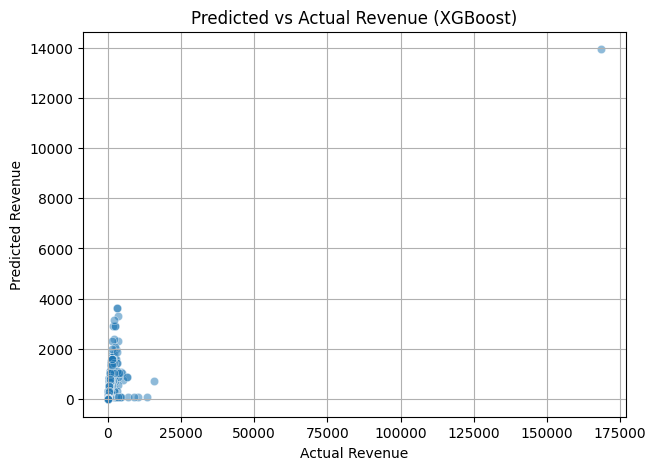

In [15]:
# Visualize predictions
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test_real, y=y_pred_best_real, alpha=0.5)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Predicted vs Actual Revenue (XGBoost)')
plt.grid(True)
plt.show()
